In [1]:
import geopandas as gpd
import pandas as pd
import time

from obia.handlers import open_geotiff
from obia.segment import segment
from obia.classify import classify

In [2]:
def reassign_class(x):
    if x not in keep_classes:
        return 0
    else:
        return x

start_time = time.time()
max_obs = 2000

training_path = "/mnt/c/tmp/output/Merge2.geojson"

keep_classes = [1, 2, 4, 8, 9, 12, 13, 16]
training_segments = gpd.read_file(training_path)
training_segments = training_segments.dropna()

training_segments = training_segments.drop(columns=['OBJECTID', 'Shape_Length', 'Shape_Area'])
training_segments['feature_class'] = training_segments['feature_class'].apply(reassign_class)

classes = training_segments['feature_class'].unique()

for cls in classes:
    count = training_segments[training_segments['feature_class'] == cls].shape[0]

    if count > max_obs:
        drop_indices = training_segments[training_segments['feature_class'] == cls].index[max_obs:]
        training_segments = training_segments.drop(drop_indices)



raster_path = "/mnt/c/tmp/output/output_163.tif"

image = open_geotiff(raster_path)
segmented_image = segment(
    image, segmentation_bands=[7,4,1],
    method="slic", n_segments=25000, compactness=10, max_num_iter=100, sigma=0.5, convert2lab=True, slic_zero=True
)
classified = classify(image, segmented_image, training_segments, method='mlp', compute_shap=True, solver='lbfgs')
classified.write_geotiff("/mnt/c/tmp/output/classified_163.tif")
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time}")

/home/milo/miniconda3/envs/gdal_env/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
100%|██████████| 23633/23633 [3:10:32<00:00,  2.07it/s]  
Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1000 [00:00<?, ?it/s]

AttributeError: 'Image' object has no attribute 'image_data'

In [100]:
import numpy as np
import shap

from PIL.Image import fromarray
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

from obia.handlers import _write_geotiff


class ClassifiedImage:
    classified_image = None
    confusion_matrix = None
    report = None
    params = None
    shap_values = None
    crs = None
    transform = None

    def __init__(self, classified_image, confusion_matrix, report, shap_values, transform, crs, params):
        self.classified_image = classified_image
        self.report = report
        self.confusion_matrix = confusion_matrix
        self.shap_values = shap_values
        self.params = params
        self.transform = transform
        self.crs = crs

    def write_geotiff(self, output_path):
        _write_geotiff(self.classified_image, output_path, self.crs, self.transform)


def classify(image, segmented_image, training_classes,
             method='rf', test_size=0.5, compute_reports=False,
             compute_shap=False, **kwargs):
    shap_values = None
    x = training_classes.drop(['feature_class', 'geometry', 'segment_id'], axis=1)
    y = training_classes['feature_class']

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)

    scaler = StandardScaler()
    scaler.fit(x_train)  # Fit scaler to training data
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test) 

    if method == 'rf':
        classifier = RandomForestClassifier(**kwargs)
    elif method == 'mlp':
        classifier = MLPClassifier(**kwargs)
    else:
        raise ValueError('An unsupported classification algorithm was requested')

    classifier.fit(x_train, y_train)
    if compute_shap:
        explainer = None
        if isinstance(classifier, RandomForestClassifier):
            explainer = shap.TreeExplainer(classifier)
        elif isinstance(classifier, MLPClassifier):
            explainer = shap.KernelExplainer(classifier.predict_proba, x_train)

        shap_values = explainer(x_train)

    y_pred = classifier.predict(x_test)

    report = None
    cm = None
    if compute_reports:
        cm = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred)


    df = segmented_image.segments[list(training_classes.columns.values)]
    
    x_pred = df.drop(['feature_class', 'geometry', 'segment_id'], axis=1, errors='ignore')
    x_pred = scaler.transform(x_pred)

    y_pred_all = classifier.predict(x_pred)

    params = classifier.get_params()
    segment_ids = df['segment_id'].to_list()

    classified_img = np.zeros((image.img_data.shape[0], image.img_data.shape[1]))

    for i, segment_id in enumerate(segment_ids):
        idx = np.argwhere(segmented_image._segments == segment_id)
        for j in idx:
            classified_img[j[0], j[1]] = y_pred_all[i]

    return ClassifiedImage(classified_img, cm, report, shap_values, image.transform, image.crs, params)


# todo: add CNN classifier. Follow procedure of https://www.mdpi.com/2072-4292/13/14/2709#. simply plot each segment and assign a class then classify each plotted segment. seems super inneficient, but maybe more powerful? probably not though. RF or MLP should be just as good... but maybe not.

In [14]:
training_segments = gpd.read_file(training_path)
training_segments = training_segments.dropna()
training_segments['feature_class'].dtype

dtype('O')

In [78]:
list(training_segments.columns.values)

['OBJECTID',
 'segment_id',
 'feature_class',
 'b0_min',
 'b0_max',
 'b0_mean',
 'b0_variance',
 'b0_skewness',
 'b0_kurtosis',
 'b0_contrast',
 'b0_dissimilarity',
 'b0_homogeneity',
 'b0_ASM',
 'b0_energy',
 'b0_correlation',
 'b1_min',
 'b1_max',
 'b1_mean',
 'b1_variance',
 'b1_skewness',
 'b1_kurtosis',
 'b1_contrast',
 'b1_dissimilarity',
 'b1_homogeneity',
 'b1_ASM',
 'b1_energy',
 'b1_correlation',
 'b2_min',
 'b2_max',
 'b2_mean',
 'b2_variance',
 'b2_skewness',
 'b2_kurtosis',
 'b2_contrast',
 'b2_dissimilarity',
 'b2_homogeneity',
 'b2_ASM',
 'b2_energy',
 'b2_correlation',
 'b3_min',
 'b3_max',
 'b3_mean',
 'b3_variance',
 'b3_skewness',
 'b3_kurtosis',
 'b3_contrast',
 'b3_dissimilarity',
 'b3_homogeneity',
 'b3_ASM',
 'b3_energy',
 'b3_correlation',
 'b4_min',
 'b4_max',
 'b4_mean',
 'b4_variance',
 'b4_skewness',
 'b4_kurtosis',
 'b4_contrast',
 'b4_dissimilarity',
 'b4_homogeneity',
 'b4_ASM',
 'b4_energy',
 'b4_correlation',
 'b5_min',
 'b5_max',
 'b5_mean',
 'b5_varia

In [122]:
def reassign_class(x):
    if x not in keep_classes:
        return 0
    else:
        return x
        
# keep_classes = [1, 2, 4, 8, 9, 12, 13, 16]
keep_classes = [1, 2, 4, 8, 9]
drop_classes = [16, 3, 5, 6, 7, 10, 13, 14, 15]

# training = training_segments.drop(columns=['OBJECTID', 'Shape_Length', 'Shape_Area',])
columns_to_keep = [
    'segment_id', 'feature_class',
    'b1_mean', 
    'b4_mean',
    'b7_mean', 
    'b7_dissimilarity',
    'b7_correlation',
    'geometry'
    ]

training = training_segments[columns_to_keep]
training = training[~training['feature_class'].isin(drop_classes)]

training['feature_class'] = training['feature_class'].astype(int)

training['feature_class'] = training['feature_class'].apply(reassign_class)
classes = training['feature_class'].unique()

training['feature_class'].value_counts()

feature_class
8    28989
2      926
1      423
0      345
9       68
4       38
Name: count, dtype: int64

In [87]:
training.head()

,segment_id,feature_class,b1_mean,b4_mean,b7_mean,b7_variance,b7_homogeneity,b6_correlation,geometry
0,42,8,120.939560,142.730769,150.181319,17.247343,0.999922,0.246320,"POLYGON ((201849.167 2185453.421, 201849.167 2..."
1,43,8,125.220339,145.491525,156.197740,26.260334,0.999925,0.251980,"POLYGON ((201855.390 2185453.421, 201855.390 2..."
2,44,8,116.178571,140.005952,152.916667,24.362103,0.999924,0.173710,"POLYGON ((201862.570 2185453.421, 201862.570 2..."
3,45,8,117.805369,140.275168,149.872483,39.829377,0.999928,0.065005,"POLYGON ((201868.315 2185453.421, 201868.315 2..."
4,46,8,120.022727,139.825758,162.090909,45.552342,0.999937,0.071432,"POLYGON ((201873.101 2185453.421, 201873.101 2..."


In [118]:
import geopandas as gpd
import rasterio
from rasterio.features import shapes
import numpy as np


def raster_to_vector(raster, value, transform):
    """
    Convert a raster into a vector (Polygon).

    Args:
        raster(numpy.array): A 2D numpy array representing the raster.
        value(int): Value of pixels to be used for generating polygons.
        transform (Affine): A rasterio.Affine class instance representing the transformation matrix.

    Returns:
        Geopandas GeoDataFrame representation.
    """
    mask = None if value is None else (raster == value)
    shapes_gen = shapes(raster, mask=mask, transform=transform)
    poly_dict_list = []
    for poly_dict, val in shapes_gen:
        new_dict = {'properties': {'value': val}, 'geometry': poly_dict}
        poly_dict_list.append(new_dict)
    vector_df = gpd.GeoDataFrame.from_features(poly_dict_list)
    return vector_df




def write_vector_to_geopackage(vector, filepath):
    """
    Write a vector into a geopackage file (.gpkg).

    Args:
        vector(GeoDataFrame): The vector data in GeoDataFrame format.
        filepath(str): The file path where the results should be written.
    """
    vector.to_file(filepath, driver='GPKG')



In [123]:
classified = classify(image, segmented_image, training, method='mlp', compute_shap=False, hidden_layer_sizes=(100, ), solver='lbfgs', max_iter=10000)

vector = raster_to_vector(classified.classified_image.astype(np.int16), None, image.transform)

write_vector_to_geopackage(vector, "/mnt/c/tmp/output/classified_163_4.gpkg")

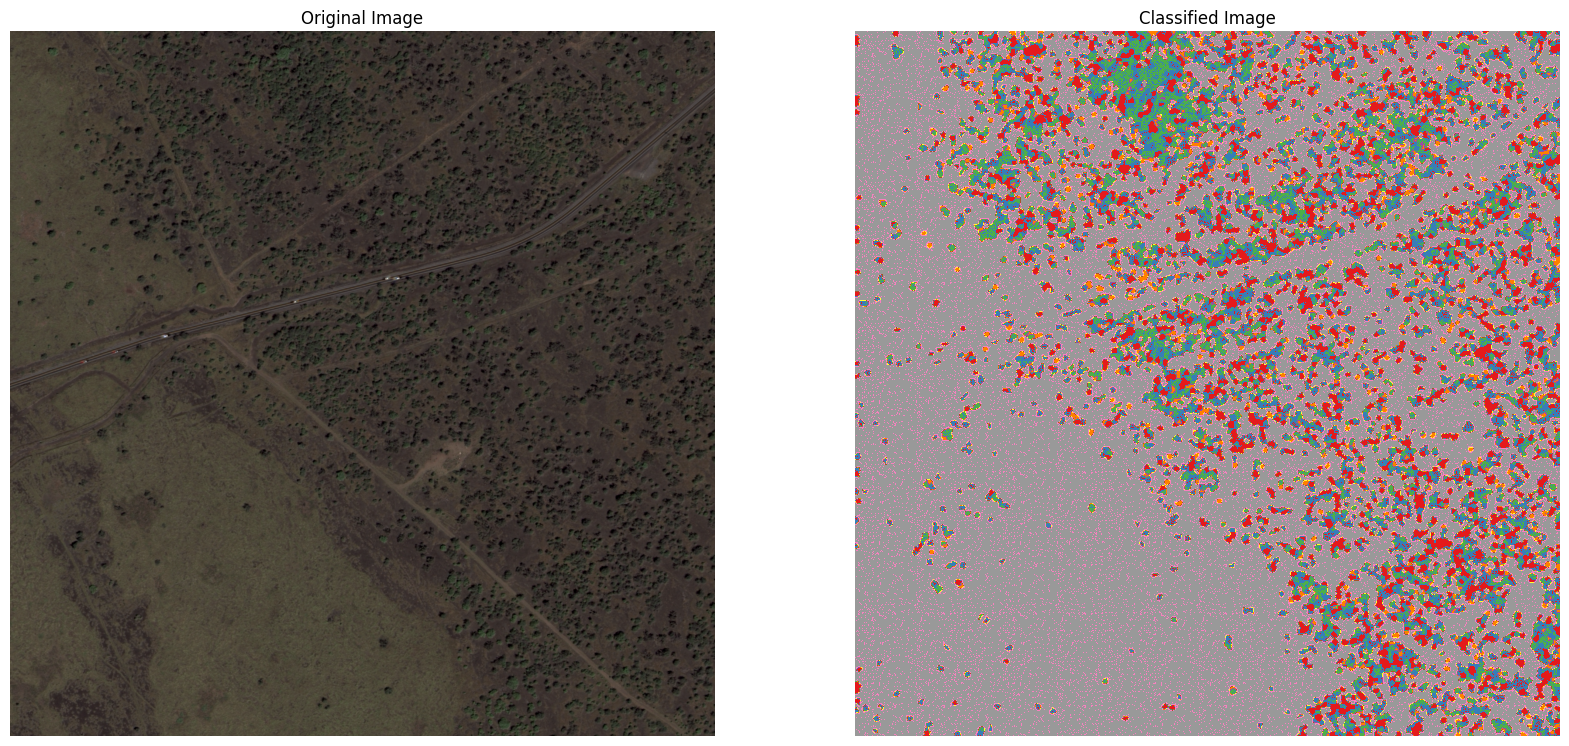

In [113]:

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

im = image.to_image(bands=[4, 2, 1])
axs[0].imshow(im)
axs[0].axis('off')
axs[0].set_title('Original Image')

axs[1].imshow(classified.classified_image, cmap='Set1')
axs[1].axis('off')
axs[1].set_title('Classified Image') 
plt.show()

In [115]:
classified.write_geotiff("/mnt/c/tmp/output/classified_163_2.tif")

Done Writing GeoTIFF at /mnt/c/tmp/output/classified_163_2.tif


In [103]:
np.unique(classified.classified_image)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
vars = training_segments.drop(['feature_class', 'geometry', 'segment_id'], axis=1, errors='ignore')
shap_values = classified.shap_values
shap.summary_plot(
    [shap_values[:, :, class_ind].values for class_ind in range(shap_values.shape[-1])],
    feature_names=vars.columns
)